# **Business Expansion**

---
---

Whether a person owns one restaurant or 20, expansion takes careful planning and consideration. There has to be a considerable strategy that’ll help set up next location up for success. Any brand of restaurant while expanding in a particular location desires that is particular location has a similar or a more promising market environment than the previous one.


After deciding the location which is most similar to the previous location, it is also desired to know about the most competing restaurants in that area so that we can study them and build a strategy to become better than them.

This project aims any company or business, which might be thinking that it’s time to expand their business into another city for growth. 


## **Steps :**

1. Importing the required Libraries
2. Data Preparation
    * Loading Data
    * Visualizing Data
    * Normalizing Data
    * Using Foursquare API to generate Neighborhood Venue Informations.
3. Exploratory Data Analysis
    * Total number of Venue categories
    * No. of Venues per Neighborhood
4. Data Preprocessig
    * One Hot Encoding
    * Creating Venue_preference Dataset
    * Creating Neighborhood Preference Dataset
5. Model
    * Finding the optimum k Value using Elbow Method
    * Clustering the Data into Groups
    * Visualizing the Data
6. Use Case and Results
7. Conclusions

## **1. Importing all the Required Libraries**
---

In [1]:
!pip install folium
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import requests
import folium 
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans

## **2. Loading the Dataset and Preprocessing**
---

> **Data is collected as explained in the [Report]() and a csv file is made of the complete dataset shown below.**

In [2]:
df = pd.read_csv("Downloads/complete_dataset.csv")

In [3]:
df.head()

,Borough,Neighborhoods,Latitude,Longitude,Population,City,AverageIncome
0,SouthernSuburbs,Anjanapura,12.8604,77.5612,940039,Bangalore,44218.92255
1,SouthernSuburbs,Arekere,12.8875,77.5970,138760,Bangalore,29378.71663
2,Southern,Banashankari,12.9255,77.5468,810407,Bangalore,57524.20953
3,NorthEastern,Banaswadi,13.0120,77.6471,632031,Bangalore,53349.70118
4,Southern,Basavanagudi,12.9421,77.5754,426903,Bangalore,63161.96222


> **Visualising Data**

In [4]:
bangalore_latitude = df['Latitude'].mean()
bangalore_longitude = df['Longitude'].mean()
print("Latitude of Bangalore is : ",bangalore_latitude)
print("Longitude of bangalore is : ",bangalore_longitude)

Latitude of Bangalore is :  12.962339620312502
Longitude of bangalore is :  77.601752946875


In [5]:
unique_boroughs_of_bangalore = df['Borough'].unique().tolist()

In [6]:
print(unique_boroughs_of_bangalore)

['SouthernSuburbs', 'Southern', 'NorthEastern', 'Western', 'Eastern', 'SouthEastern', 'Central', 'Northern']


In [7]:
borough_colors ={}
for i in unique_boroughs_of_bangalore:
    borough_colors[i] = '#%02X%02X%02X' % tuple(np.random.choice(range(256),size=3))

In [8]:
bangalore_map = folium.Map(location=[bangalore_latitude,bangalore_longitude],zoom_start=12,control_scale=True)

In [9]:
for lat,lng,boro,nei in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhoods']):
    label_text = boro + ' - ' + nei
    label = folium.Popup(label_text,parse_html=True)
    folium.CircleMarker([lat,lng], tooltip = label_text, radius = 4, popup = label, color=borough_colors[boro], fill=True, 
                        fill_color = borough_colors[boro], fill_opacity=0.7).add_to(bangalore_map)

In [10]:
bangalore_map

> **Generating "Normalised" Population and Average Income as both are very important features and scaled differently.**

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))
df['Normalized_Population'] = pd.DataFrame(scaler.fit_transform(df['Population'].values.reshape(-1,1)))
df['Normalized_Income'] = pd.DataFrame(scaler.fit_transform(df['AverageIncome'].values.reshape(-1,1)))

In [14]:
df.head()

,Borough,Neighborhoods,Latitude,Longitude,Population,City,AverageIncome,Normalized_Population,Normalized_Income
0,SouthernSuburbs,Anjanapura,12.8604,77.5612,940039,Bangalore,44218.92255,0.955027,0.655989
1,SouthernSuburbs,Arekere,12.8875,77.5970,138760,Bangalore,29378.71663,0.128036,0.406048
2,Southern,Banashankari,12.9255,77.5468,810407,Bangalore,57524.20953,0.821235,0.880079
3,NorthEastern,Banaswadi,13.0120,77.6471,632031,Bangalore,53349.70118,0.637135,0.809771
4,Southern,Basavanagudi,12.9421,77.5754,426903,Bangalore,63161.96222,0.425425,0.975031


> **Using foursquare to fetch the nearest Venue locations**

In [15]:
# Defining Credentials
CLIENT_ID = 'WWV1AAMBFNMWGEEDEZXZXIF5IY2V5CPDGGZHOXVVYU4O1Z1E'
CLIENT_SECRET = 'PKTKDUPRK2YVKOGTQPN0LCCGUQOJ2M21CUZNZMB33IK3FPTA'
VERSION = '20180606'
LIMIT = 150

In [16]:
def getNearbyVenues(names, boro, latitudes, longitudes, radius=1000):
    venues_list=[]
    for name, boro, lat, lng in zip(names, boro, latitudes, longitudes):
        print("Fetching venues for : ",name)            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(name, boro, lat, lng, v['venue']['name'], v['venue']['location']['lat'],v['venue']['location']['lng'],
                             v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhoods','Borough','Neighborhood Latitude','Neighborhood Longitude','Venue','Venue Latitude',
                             'Venue Longitude','Venue Category']
    return(nearby_venues)

In [17]:
bangalore_venues = getNearbyVenues(names=df['Neighborhoods'],latitudes=df['Latitude'],longitudes=df['Longitude'],boro=df['Borough'])

Fetching venues for :  Anjanapura
Fetching venues for :  Arekere
Fetching venues for :  Banashankari
Fetching venues for :  Banaswadi
Fetching venues for :  Basavanagudi
Fetching venues for :  Basaveshwaranagar
Fetching venues for :  Begur
Fetching venues for :  Bellandur
Fetching venues for :  Bommanahalli
Fetching venues for :  Bommasandra
Fetching venues for :  BTM Layout
Fetching venues for :  Cantonment area
Fetching venues for :  CV Raman Nagar
Fetching venues for :  Domlur
Fetching venues for :  Electronic City
Fetching venues for :  Girinagar
Fetching venues for :  Gottigere
Fetching venues for :  HBR Layout
Fetching venues for :  Hebbal
Fetching venues for :  Hoodi
Fetching venues for :  Horamavu
Fetching venues for :  HSR Layout
Fetching venues for :  Hulimavu
Fetching venues for :  Indiranagar
Fetching venues for :  J. P. Nagar
Fetching venues for :  Jalahalli
Fetching venues for :  Jayanagar
Fetching venues for :  Jeevanbheemanagar
Fetching venues for :  Kamakshipalya
Fetch

In [18]:
print("Total number of venues found in Bangalore are : ",bangalore_venues.shape[0])

Total number of venues found in Bangalore are :  1695


In [19]:
bangalore_venues.head()

,Neighborhoods,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Anjanapura,SouthernSuburbs,12.8604,77.5612,State Bank of India ATM,12.861650,77.561634,ATM
1,Anjanapura,SouthernSuburbs,12.8604,77.5612,capital club resorts,12.855979,77.555653,Pool
2,Anjanapura,SouthernSuburbs,12.8604,77.5612,Accenture,12.858980,77.569510,Business Service
3,Anjanapura,SouthernSuburbs,12.8604,77.5612,Axis Bank ATM,12.868820,77.559060,ATM
4,Arekere,SouthernSuburbs,12.8875,77.5970,Decathlon Sports India Pvt Ltd,12.887513,77.597712,Sporting Goods Shop


## **3. Exploratory Data Analysis**
---

> **The total number of unique categories in Bangalore**

In [20]:
len(bangalore_venues['Venue Category'].unique())

180

> **Getting Number of venues per neighborhood**

In [21]:
individual_bangalore_venue_count = bangalore_venues.groupby(['Borough','Neighborhoods'])['Borough'].count().to_frame()
individual_bangalore_venue_count.rename(columns={'Borough':'NumberOfVenues'},inplace=True)
individual_bangalore_venue_count.reset_index(inplace=True)

In [22]:
individual_bangalore_venue_count.head()

,Borough,Neighborhoods,NumberOfVenues
0,Central,Cantonment area,28
1,Central,Domlur,87
2,Central,Indiranagar,100
3,Central,Jeevanbheemanagar,27
4,Central,Malleswaram,40


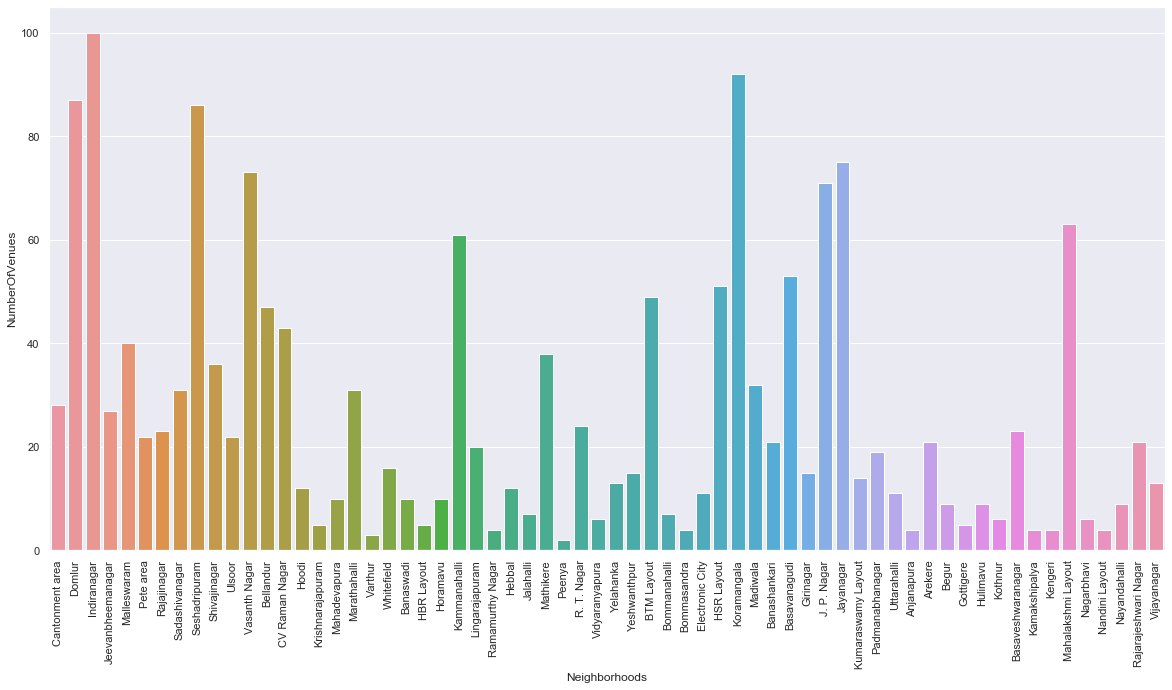

In [23]:
sns.set(rc={'figure.figsize':(20,10)})
plot = sns.barplot(x='Neighborhoods',y='NumberOfVenues',data=individual_bangalore_venue_count)
plot = plot.set_xticklabels(individual_bangalore_venue_count['Neighborhoods'],rotation=90)

## **4. Data Preprocessing**
---

Now two DataFrames will be created and worked on,

1. **venue_preference**

2. **neighborhood_preferecne**

"neighborhood_preference" will contain only those columns that will help in K- Means Clustering 

In "venue_preference", top 10 venues in each neighborhood will be stored in decreasing order of their importance.

> **One hot encoding to compare venues based on some common scale**

In [24]:
bangalore_venues_onehot = pd.get_dummies(bangalore_venues[['Venue']])
bangalore_venues_onehot['Neighborhoods'] = bangalore_venues['Neighborhoods']
bangalore_venues_grouped = bangalore_venues_onehot.groupby('Neighborhoods').mean().reset_index()
bangalore_venues_grouped.head()

,Neighborhoods,Venue_1131 Bar N Kitchen,Venue_1522 - The Pub,Venue_1522- The Pub,Venue_153 Biere Street,Venue_154 breakfast club,Venue_18 CHINA TOWN,Venue_1947,Venue_24/7 @ Lalit Ashok,Venue_24th Main,...,Venue_refresh,Venue_sagar,"Venue_shastri sagar,peenya",Venue_sumanahalli Bus Stop,Venue_tasty hot,Venue_tender chicken nehru road,Venue_the SQUARE,Venue_vijayanagar water tank,Venue_wow! momo,Venue_ಗೋಪಾಲ್ ಕ್ಯಾಂಟೀನ್ (Gopal Canteen)
0,Anjanapura,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Arekere,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,BTM Layout,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Banashankari,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Banaswadi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


> **Defining a Function to return the top 10 most Popular Venues in a Neighborhood**

In [25]:
def return_most_common_venues(row, number_of_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:number_of_top_venues]

In [26]:
number_of_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhoods']
for i in np.arange(number_of_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(i+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(i+1))

# create a new dataframe
venue_preference = pd.DataFrame(columns=columns)
venue_preference['Neighborhoods'] = bangalore_venues_grouped['Neighborhoods']

for i in np.arange(bangalore_venues_grouped.shape[0]):
    venue_preference.iloc[i, 1:] = return_most_common_venues(bangalore_venues_grouped.iloc[i, :], number_of_top_venues)

venue_preference.head()

,Neighborhoods,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Anjanapura,Venue_capital club resorts,Venue_Accenture,Venue_Axis Bank ATM,Venue_State Bank of India ATM,Venue_ಗೋಪಾಲ್ ಕ್ಯಾಂಟೀನ್ (Gopal Canteen),Venue_Goli Vadapav,Venue_Gold's Gym,Venue_Gold's gym,Venue_Golds Gym,Venue_Goli
1,Arekere,Venue_Domino's Pizza,Venue_Cafe Coffee Day,Venue_Reliance Mart,Venue_Baskin-Robbins,Venue_Pizza Hut,Venue_Benison Super Market,Venue_Natural Ice Cream,Venue_Adyar Anand Bhavan ( A2B ),Venue_Baker's Stop,Venue_Beijing Bites
2,BTM Layout,Venue_Cafe Coffee Day,Venue_Subway,Venue_Domino's Pizza,Venue_Faaso's,Venue_Cafe Orio,Venue_Narmadha's Hyderabad Biriyani,Venue_Core Fitness,Venue_Marwa Restuarant,Venue_McDonald's,Venue_Flavour Square
3,Banashankari,Venue_Domino's Pizza,Venue_Corner Adda,Venue_Anna Kuteera,Venue_Croma,Venue_Pizza Hut,Venue_Cafe coffee day,Venue_Caf-Eleven,Venue_Adyar Ananda Bhavan,Venue_Kamakya theatre,Venue_Hotel Prashanth
4,Banaswadi,Venue_Al Amanah,Venue_Manasa Fish Land,Venue_Saffron,Venue_Tamarind,Venue_Cafe Coffee Day,Venue_Just kebabs,Venue_Trust Chemists & Druggists,Venue_Sri Balaji Bhandar,Venue_Amma Pasteries,Venue_Uttam Sagar Deluxe Restaurant


> **Creating Neighborhood Preference Dataset**

In [27]:
neighborhood_preference = df.drop(['Population', 'AverageIncome', 'City'], axis= 1)

In [28]:
neighborhood_preference.head()

,Borough,Neighborhoods,Latitude,Longitude,Normalized_Population,Normalized_Income
0,SouthernSuburbs,Anjanapura,12.8604,77.5612,0.955027,0.655989
1,SouthernSuburbs,Arekere,12.8875,77.5970,0.128036,0.406048
2,Southern,Banashankari,12.9255,77.5468,0.821235,0.880079
3,NorthEastern,Banaswadi,13.0120,77.6471,0.637135,0.809771
4,Southern,Basavanagudi,12.9421,77.5754,0.425425,0.975031


In [29]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le1 = LabelEncoder()

In [30]:
neighborhood_preference['Neighborhoods'] = le.fit_transform(neighborhood_preference['Neighborhoods'])
neighborhood_preference['Borough'] = le1.fit_transform(neighborhood_preference['Borough'])

In [31]:
neighborhood_preference['Ranking'] = neighborhood_preference['Normalized_Population'] * 0.5 + neighborhood_preference['Normalized_Income'] * 0.35

## **5. Building the K-Means Clusters**
---

> **Finding the optimum *K* value using Elbow method**

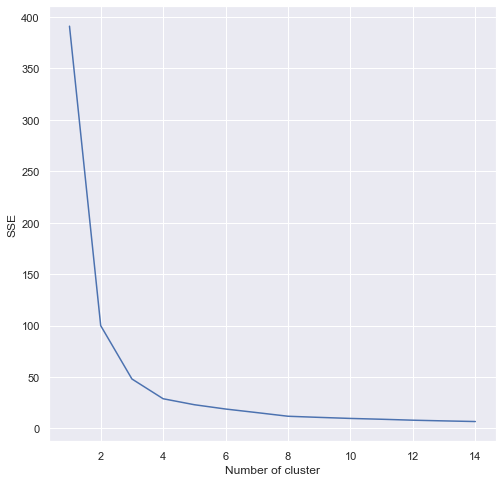

In [32]:
sse = {}
for k in range(1,15):
    kmeans = KMeans(n_clusters=k,random_state=0)
    kmeans.fit(neighborhood_preference.drop('Neighborhoods',axis=1))
    bangalore_venues_grouped['Cluster'] = kmeans.labels_
    sse[k] = kmeans.inertia_

plt.figure(figsize = (8,8))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

From the above graph, we can see the optimal value for cluster is 4.

> **Clustering the Data into Groups**

In [33]:
kmeans = KMeans(n_clusters=4,random_state=0)
kmeans.fit(neighborhood_preference.drop('Neighborhoods',axis=1))
neighborhood_preference['Cluster'] = kmeans.labels_

In [34]:
# Label Decoding
neighborhood_preference['Neighborhoods'] = le.inverse_transform(neighborhood_preference['Neighborhoods'])
neighborhood_preference['Borough'] = le1.inverse_transform(neighborhood_preference['Borough'])

In [35]:
neighborhood_preference.groupby('Cluster')['Neighborhoods'].count()

Cluster
0    15
1    14
2    20
3    15
Name: Neighborhoods, dtype: int64

In [36]:
neighborhood_preference.head()

,Borough,Neighborhoods,Latitude,Longitude,Normalized_Population,Normalized_Income,Ranking,Cluster
0,SouthernSuburbs,Anjanapura,12.8604,77.5612,0.955027,0.655989,0.707110,0
1,SouthernSuburbs,Arekere,12.8875,77.5970,0.128036,0.406048,0.206135,0
2,Southern,Banashankari,12.9255,77.5468,0.821235,0.880079,0.718645,3
3,NorthEastern,Banaswadi,13.0120,77.6471,0.637135,0.809771,0.601988,1
4,Southern,Basavanagudi,12.9421,77.5754,0.425425,0.975031,0.553973,3


> **Visualizing the Data**

In [37]:
# create map
map_clusters = folium.Map(location=[bangalore_latitude, bangalore_longitude], zoom_start=11)

In [38]:
# set color scheme for the clusters
x = np.arange(5)
ys = [i + x + (i*x)**2 for i in range(5)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighborhood_preference['Latitude'], neighborhood_preference['Longitude'], neighborhood_preference['Neighborhoods'], neighborhood_preference['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

In [39]:
map_clusters

## **6. Use Case**
---

**Predicting Results**

For a given Neighborhood,

1. Its cluster will be find out.
2. All the neighborhoods will be found in that cluster
3. The top 3 neighborhood having best ranking will be selected and then will be mergred with venue_prefernce to display the final results.


In [40]:
target_cluster_dataframe = neighborhood_preference.loc[neighborhood_preference['Neighborhoods']=='Banashankari']
target_cluster_dataframe.reset_index()
target_cluster = target_cluster_dataframe.iloc[0].at['Cluster']
target_cluster
print("The target cluster is : ",target_cluster)

The target cluster is :  3


In [41]:
possible_neighborhoods = neighborhood_preference[neighborhood_preference['Cluster']==target_cluster]
possible_neighborhoods.head()

,Borough,Neighborhoods,Latitude,Longitude,Normalized_Population,Normalized_Income,Ranking,Cluster
2,Southern,Banashankari,12.9255,77.5468,0.821235,0.880079,0.718645,3
4,Southern,Basavanagudi,12.9421,77.5754,0.425425,0.975031,0.553973,3
8,SouthEastern,Bommanahalli,12.8984,77.6179,0.745644,0.103626,0.409091,3
9,SouthEastern,Bommasandra,12.8168,77.6989,0.731856,0.327855,0.480677,3
10,SouthEastern,BTM Layout,12.9166,77.6101,0.847384,0.741745,0.683303,3


In [42]:
print("There are {} neighborhoods which has similar characteristics to Banashankari.".format(possible_neighborhoods.shape[0]))

There are 15 neighborhoods which has similar characteristics to Banashankari.


In [43]:
recommended_neighborhoods = possible_neighborhoods.sort_values(by='Ranking',ascending=False)
recommended_neighborhoods.reset_index(inplace=True, drop=True)

In [44]:
recommended_neighborhoods

,Borough,Neighborhoods,Latitude,Longitude,Normalized_Population,Normalized_Income,Ranking,Cluster
0,Southern,Banashankari,12.925500,77.546800,0.821235,0.880079,0.718645,3
1,Southern,Uttarahalli,12.907000,77.552100,0.730264,0.975102,0.706418,3
2,SouthEastern,BTM Layout,12.916600,77.610100,0.847384,0.741745,0.683303,3
3,Southern,Girinagar,12.938600,77.544000,0.793501,0.604236,0.608233,3
4,Southern,Basavanagudi,12.942100,77.575400,0.425425,0.975031,0.553973,3
5,Southern,Kumaraswamy Layout,12.903800,77.561800,1.000000,0.095524,0.533433,3
6,Southern,Padmanabhanagar,12.915600,77.556800,0.564219,0.707752,0.529823,3
7,SouthEastern,Madiwala,12.922600,77.617400,0.915415,0.164316,0.515218,3
8,SouthEastern,HSR Layout,12.908100,77.647600,0.536576,0.681594,0.506846,3
9,SouthEastern,Bommasandra,12.816800,77.698900,0.731856,0.327855,0.480677,3


> **Predicting Results**

In [45]:
possible_venues = venue_preference[venue_preference['Neighborhoods']=='Uttarahalli']
possible_venues = possible_venues.append(venue_preference[venue_preference['Neighborhoods']=='BTM Layout'])
possible_venues = possible_venues.append(venue_preference[venue_preference['Neighborhoods']=='Girinagar'])

possible_venues.head()

,Neighborhoods,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
56,Uttarahalli,Venue_Masala,Venue_Domino's Pizza,Venue_Kaggis Bake Shop,Venue_More 4 U,Venue_Stop N Joy,Venue_Moksha,Venue_Kanti Sweets,Venue_Goli Vadapav,Venue_Cafe Coffee Day,Venue_Shanti Sagar
2,BTM Layout,Venue_Cafe Coffee Day,Venue_Subway,Venue_Domino's Pizza,Venue_Faaso's,Venue_Cafe Orio,Venue_Narmadha's Hyderabad Biriyani,Venue_Core Fitness,Venue_Marwa Restuarant,Venue_McDonald's,Venue_Flavour Square
15,Girinagar,Venue_Domino's Pizza,Venue_Seetha Circle,Venue_Cuppa,Venue_Aahar Utsav veg,Venue_New Sagar Fast Food,Venue_Roti Land Dhaba,Venue_Sri Guru Juice Center,Venue_Aithal's Mithra Koota,Venue_Just Bake,Venue_Sharon Juice Point


## **7. Conclusions**
---


**Here, according the data, we see that 'Uttarahalli','BTM Layout' and 'Girinagar' are top 3 neighborhoods with similar market than 'Banashankari' where our previous Restaurant is located.**

**Our model futher tells top 10 venues in that location**